# Sommaire

1. [Chargement des données et préparation à l'analyse](#open)
    * [Conclusion](#result)
2. [Métriques](#metrics)
    * [Métriques de contenu](#product_metrics)
        * [Evaluation de l'activité utilisateur](#dau_wau_mau)
        * [Nombre moyen de sessions par jour qu'un utilisateur effectue](#n_sessions)
        * [Durée moyenne de la session ASL](#asl)
        * [Taux de rétention](#retention_rate)
        * [Conclusion](#result_product_metrics)
    * [Métriques de commerce électronique](#e_commerce_metrics)
        * [Temps jusqu'au premier achat](#buy_time)
        * [Revenu mensuel par utilisateur](#revenue)
        * [Nombre moyen d'achats par client sur une période de 6 mois](#n_buys) 
        * [Valeur moyenne des commandes](#revenue_avg)
        * [LTV (lifetime value)](#ltv)
        * [Conclusion](#result_e_commerce_metrics)
    * [Métriques marketing](#marketing_metrics)
        * [Dépensent en marketing](#marketing_costs)
        * [Coût d'acquisition client CAC](#cac)
        * [ROMI par cohorte par source](#romi)
3. [Conclusion](#result_total)

# Chargement des données et préparation à l'analyse <a id="open"></a>

Charger les bibliothèques.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy import stats as st

In [2]:
visits1 = '/datasets/visits_log.csv'
visits2 = 'https://code.s3.yandex.net/datasets/visits_log.csv'

def open_csv(link1, link2):
    try:
        data = pd.read_csv(link1, sep = ',')
    except FileNotFoundError:
        data = pd.read_csv(link2, sep = ',')
    return data
    
visits = open_csv(visits1, visits2)
display(visits.head(10))
print()
visits.info()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [3]:
orders1 = '/datasets/orders_log.csv'
orders2 = 'https://code.s3.yandex.net/datasets/orders_log.csv'

orders = open_csv(orders1, orders2)
display(orders.head(10))
print()
orders.info()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [4]:
costs1 = '/datasets/costs.csv'
costs2 = 'https://code.s3.yandex.net/datasets/costs.csv'

costs = open_csv(costs1, costs2)
display(costs.head(10))
print()
costs.info()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB



Renommer les colonnes.

In [5]:
orders = orders.rename(columns={'Buy Ts': 'buy_session', 'Revenue': 'revenue', 'Uid': 'uid'}) 

In [6]:
visits = visits.rename(columns={'Device': 'device', 'End Ts': 'end_of_session', 'Source Id': 'source_id',
                      'Start Ts': 'start_of_session', 'Uid': 'uid'})

In [7]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0



Convertir les colonnes contenant des dates au format date.

In [8]:
visits['end_of_session'] = pd.to_datetime(visits['end_of_session'])
visits['start_of_session'] = pd.to_datetime(visits['start_of_session'])
orders['buy_session'] = pd.to_datetime(orders['buy_session'])
costs['dt'] = pd.to_datetime(costs['dt'])

Obtenir les valeurs uniques de la source publicitaire et de la catégorie du périphérique utilisateur.

In [9]:
visits['device'].unique()

array(['touch', 'desktop'], dtype=object)

In [10]:
visits["device"].value_counts().sort_values()

touch       96833
desktop    262567
Name: device, dtype: int64

In [11]:
# nb de source de la publicité unique
costs['source_id'].nunique()

7

In [12]:
# nb d'utilisateur unique
visits['uid'].nunique()

228169

In [13]:
# nb de source unique pour accéder au site 
visits['source_id'].nunique()

9

In [14]:
# plage de dates au tableau visits
print(visits['start_of_session'].min())
print(visits['start_of_session'].max())

2017-06-01 00:01:00
2018-05-31 23:59:00


In [15]:
# plage de dates au tableau orders
print(orders['buy_session'].min())
print(orders['buy_session'].max())

2017-06-01 00:10:00
2018-06-01 00:02:00


In [16]:
# plage de dates au tableau costs
print(costs['dt'].min())
print(costs['dt'].max())

2017-06-01 00:00:00
2018-05-31 00:00:00


## Conclusion  <a id="result"></a>

Trois tables ont été extraites avec des informations sur les visites, les commandes et les dépenses publicitaires.
- Le nombre d'utilisateurs uniques est de 228 169 personnes. 
- Les catégories de dispositifs d'accès sont "touch" et "desktop". Les visites depuis desktop sont 3 fois plus que depuis touch
- Au total, 7 sources publicitaires sont prises en compte
- il y a 9 sources de trafic vers un site web. Elles n'apportent pas toutes la même quantité de trafic.

# Métriques <a id="metrics"></a>

## Métriques de contenu <a id="product_metrics"></a>

### Evaluation de l'activité utilisateur <a id="dau_wau_mau"></a>

In [17]:
# créer les colonnes année, mois, semaine, ainsi que la date complète
visits['session_year']  = visits['start_of_session'].dt.year
visits['session_month'] = visits['start_of_session'].astype(
    'datetime64[M]')
visits['session_week']  = visits['start_of_session'].dt.week
visits['session_date'] = visits['start_of_session'].dt.date

display(visits.head())

,device,end_of_session,source_id,start_of_session,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,52,2017-12-27


In [18]:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_total = (
    visits.groupby(['session_year', 'session_week'])
    .agg({'uid': 'nunique'})
    .mean()
)
mau_total = (
    visits.groupby('session_month')
    .agg({'uid':'nunique'})
    .mean()
)    

print("Nombre d'Utilisateurs Actifs Quotidiens:", int(dau_total))
print("Nombre d'Utilisateurs Actifs Hebdomadaires:", int(wau_total))
print("Nombre d'Utilisateurs Actifs Mensuels:", int(mau_total))

Nombre d'Utilisateurs Actifs Quotidiens: 907
Nombre d'Utilisateurs Actifs Hebdomadaires: 5716
Nombre d'Utilisateurs Actifs Mensuels: 23228


In [19]:
dau_distribution = visits.groupby('session_date', as_index=False).agg({'uid': 'nunique'})

In [20]:
dau = dau_distribution.rename_axis(None, axis=1)
dau.columns=['session_date', 'n_dau']
display(dau.sort_values(by='session_date').head())

,session_date,n_dau
0,2017-06-01,605
1,2017-06-02,608
2,2017-06-03,445
3,2017-06-04,476
4,2017-06-05,820


In [21]:
# nombre maximum de visites par jour sur toute la période
dau['n_dau'].max()

3319

In [22]:
# quand
dau[dau['n_dau'] == 3319]

,session_date,n_dau
176,2017-11-24,3319


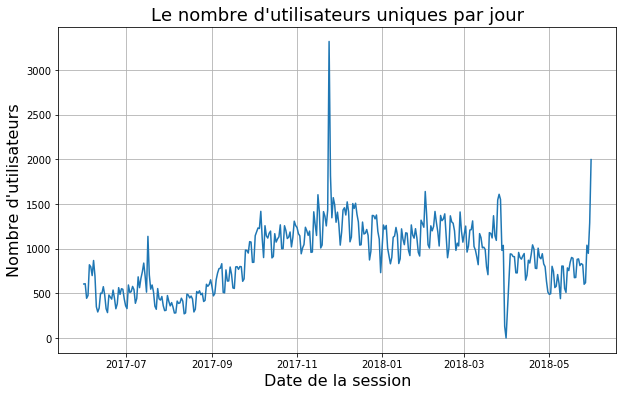

In [23]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(10, 6))
plt.title("Le nombre d'utilisateurs uniques par jour", fontsize=18) 
plt.xlabel("Date de la session", fontsize=16) 
plt.ylabel("Nombre d'utilisateurs", fontsize=16)
plt.grid()
plt.plot(dau['session_date'], dau['n_dau']) 
plt.show()

In [24]:
wau_distribution = (
    visits.groupby(['session_year', 'session_week'])
    .agg({'uid': 'nunique'})
)
wau = wau_distribution.reset_index().rename_axis(None, axis=1)
wau.columns=['session_year', 'session_month', 'n_wau']
display(wau.sort_values(by="n_wau", ascending=False).sort_values(by="n_wau", ascending = False).head(5))

,session_year,session_month,n_wau
25,2017,47,10586
27,2017,49,8407
28,2017,50,8214
26,2017,48,8166
24,2017,46,8117


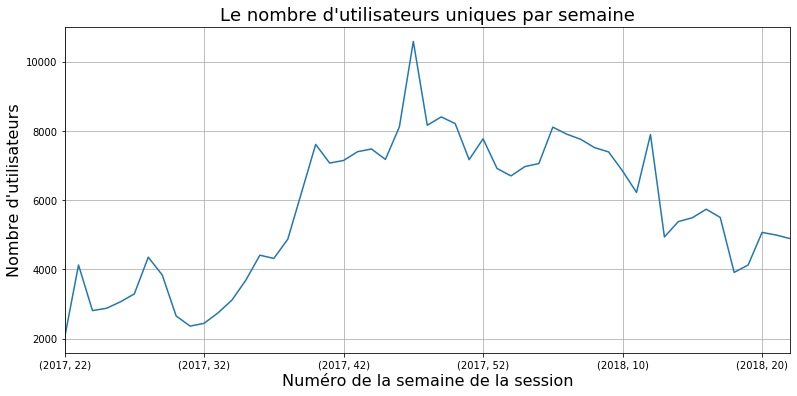

In [25]:
wau_distribution.plot(figsize = (13,6))
plt.title("Le nombre d'utilisateurs uniques par semaine", fontsize=18)
plt.xlabel("Numéro de la semaine de la session", fontsize=16)
plt.ylabel("Nombre d'utilisateurs", fontsize=16)
plt.grid()
plt.legend().remove()
plt.show()

In [26]:
mau_distribution = (
    visits.groupby(['session_month'])
    .agg({'uid': 'nunique'})
)

In [27]:
mau = mau_distribution.reset_index().rename_axis(None, axis=1)
mau.columns=['session_month', 'n_mau']
display(mau.sort_values(by="n_mau", ascending=False))

,session_month,n_mau
5,2017-11-01,32797
6,2017-12-01,31557
4,2017-10-01,29692
8,2018-02-01,28749
7,2018-01-01,28716
9,2018-03-01,27473
10,2018-04-01,21008
11,2018-05-01,20701
3,2017-09-01,18975
1,2017-07-01,14183


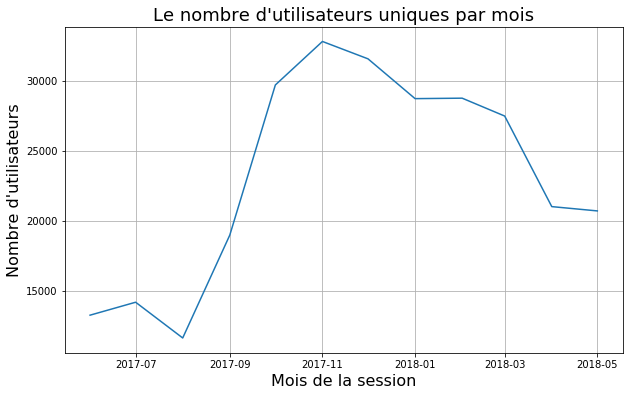

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(mau['session_month'], mau['n_mau'])
plt.title("Le nombre d'utilisateurs uniques par mois", fontsize=18) 
plt.xlabel("Mois de la session", fontsize=16) 
plt.ylabel("Nombre d'utilisateurs", fontsize=16) 
plt.grid() 
plt.show()


Les DAU, WAU et MAU ont été calculés. Le 24/11/2017 est le jour avec le plus grand nombre de visites uniques. 3319 utilisateurs ont visité le site ce jour-là. Cette semaine, ainsi que ce mois, sont les plus fréquentés. 

WAU maximale a eu 10 586 visites uniques.
MAU maximale a eu 32 797 visites uniques.

### Nombre moyen de sessions par jour effectuées par un utilisateur <a id="n_sessions"></a>

Nous allons déterminer combien de fois en moyenne les utilisateurs visitent le site par jour.

In [29]:
sessions_per_user = visits.groupby('session_date').agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
print('Nombre moyen de sessions par jour effectuées par un utilisateur:', sessions_per_user['sess_per_user'].mean().round(2))
display(sessions_per_user.head())

Nombre moyen de sessions par jour effectuées par un utilisateur: 1.08


,n_sessions,n_users,sess_per_user
session_date,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024


In [30]:
sessions_per_user_total = sessions_per_user.reset_index().rename_axis(None, axis=1)
sessions_per_user_total.columns=['session_date', 'n_sessions', 'n_users', 'sess_per_user']
display(sessions_per_user_total.head())

,session_date,n_sessions,n_users,sess_per_user
0,2017-06-01,664,605,1.097521
1,2017-06-02,658,608,1.082237
2,2017-06-03,477,445,1.071910
3,2017-06-04,510,476,1.071429
4,2017-06-05,893,820,1.089024


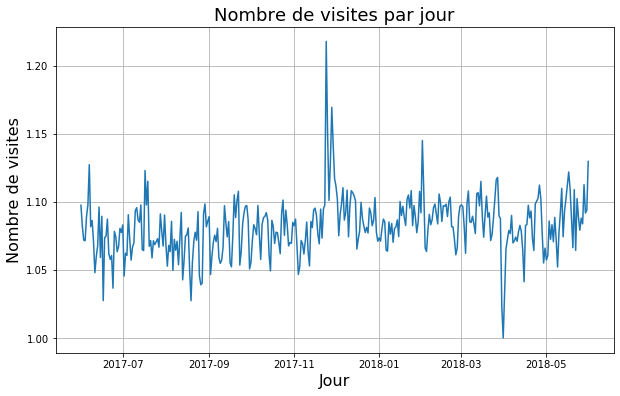

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(sessions_per_user_total['session_date'], sessions_per_user_total['sess_per_user'])
plt.title('Nombre de visites par jour', fontsize=18) 
plt.xlabel("Jour", fontsize=16) 
plt.ylabel("Nombre de visites", fontsize=16) 
plt.grid()
plt.show()

### Durée moyenne de la session ASL <a id="asl"></a>

Examinons combien de temps les utilisateurs passent sur le site.

ASL (Average Session Length)

In [32]:
visits['session_duration_sec'] = (visits['end_of_session'] - visits['start_of_session']).dt.total_seconds()
print(visits['session_duration_sec'].head())

0    1080.0
1    1680.0
2       0.0
3    1440.0
4       0.0
Name: session_duration_sec, dtype: float64


In [33]:
visits['session_duration_sec'].describe()

count    359400.000000
mean        643.025687
std         997.127761
min       -2760.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: session_duration_sec, dtype: float64

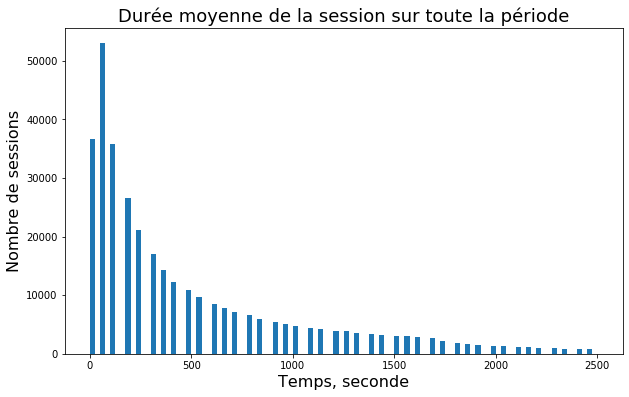

In [34]:
plt.figure(figsize=(10, 6))
visits['session_duration_sec'].hist(bins=100, range=(0, 2500))
plt.title('Durée moyenne de la session sur toute la période', fontsize=18)
plt.xlabel("Temps, seconde", fontsize=16)
plt.ylabel("Nombre de sessions", fontsize=16)
plt.grid() 
plt.show()

In [35]:
# calculons le mode, car notre distribution n'est pas normale
visits['session_duration_sec'].mode()

0    60.0
dtype: float64

In [36]:
visits['session_duration_sec'].median()

300.0

La durée moyenne de la session était de 300 secondes. 
La durée de la session la plus courante est 60 secondes.

### Taux de rétention <a id="retention_rate"></a>

Calculons le taux de rétention en appliquant une analyse de cohorte.

Identifions l'événement et la période. Sur cette base, nous formerons une cohorte. Prenons la date à laquelle l'utilisateur a été actif sur le site pour la première fois.

In [37]:
# premier jour d'activité
first_visit_date_by_customers = visits.groupby('uid')['start_of_session'].min()
first_visit_date_by_customers.name = 'first_visit_date'

visits = visits.join(first_visit_date_by_customers, on='uid')

# premier mois d'activité
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')
    
# mois de chaque visite
visits['visit_month'] = visits['start_of_session'].astype('datetime64[M]')

visits_grouped_by_cohorts = visits.groupby(
    ['first_visit_month', 'visit_month']
).agg({'uid': 'nunique'})
print(visits_grouped_by_cohorts.head())

                                 uid
first_visit_month visit_month       
2017-06-01        2017-06-01   13259
                  2017-07-01    1043
                  2017-08-01     713
                  2017-09-01     814
                  2017-10-01     909


In [38]:
display(visits.head())

,device,end_of_session,source_id,start_of_session,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_visit_date,first_visit_month,visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,51,2017-12-20,1080.0,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,8,2018-02-19,1680.0,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,26,2017-07-01,0.0,2017-07-01 01:54:00,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,20,2018-05-20,1440.0,2018-03-09 20:05:00,2018-03-01,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,52,2017-12-27,0.0,2017-12-27 14:06:00,2017-12-01,2017-12-01


In [39]:
visits['cohort_lifetime'] = (
    visits['visit_month'] - visits['first_visit_month']
)
visits['cohort_lifetime'] = (visits['cohort_lifetime'] / np.timedelta64(1, 'M')).round().astype('int')
# visits['cohort_lifetime'] = visits['cohort_lifetime'].astype('int')
print(visits['cohort_lifetime'].head())

0    0
1    0
2    0
3    2
4    0
Name: cohort_lifetime, dtype: int64


In [40]:
# regroupons les données par cohorte et son espérance de vie
cohorts = visits.groupby(
    ['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

cohorts.head(5)

,first_visit_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


In [41]:
# trouvons le nombre initial d'utilisateurs dans la cohorte
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][
    ['first_visit_month', 'uid']
]
display(initial_users_count.head(10))

,first_visit_month,uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


Calculons l'espérance de vie de l'utilisateur dans la cohorte

In [42]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

In [43]:
# regroupons les données par cohortes avec le nombre initial d'utilisateurs dans la cohorte
cohorts = cohorts.merge(initial_users_count, on='first_visit_month')
display(cohorts.head())

,first_visit_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259


In [44]:
# calculons le taux de rétention
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
display(cohorts.head())

,first_visit_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


In [45]:
retention_pivot = cohorts.pivot_table(
    index='first_visit_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
).round(2)

retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,1.0,0.08,0.05,0.06,0.07,0.07,0.06,0.06,0.05,0.05,0.04,0.04
2017-07-01,1.0,0.06,0.05,0.06,0.06,0.05,0.05,0.05,0.04,0.03,0.03,NaN
2017-08-01,1.0,0.08,0.06,0.06,0.05,0.04,0.04,0.04,0.03,0.03,NaN,NaN
2017-09-01,1.0,0.09,0.07,0.05,0.04,0.04,0.04,0.02,0.02,NaN,NaN,NaN
2017-10-01,1.0,0.08,0.05,0.04,0.03,0.03,0.02,0.02,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.08,0.04,0.04,0.03,0.02,0.02,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.06,0.04,0.03,0.02,0.02,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.06,0.04,0.02,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.06,0.03,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


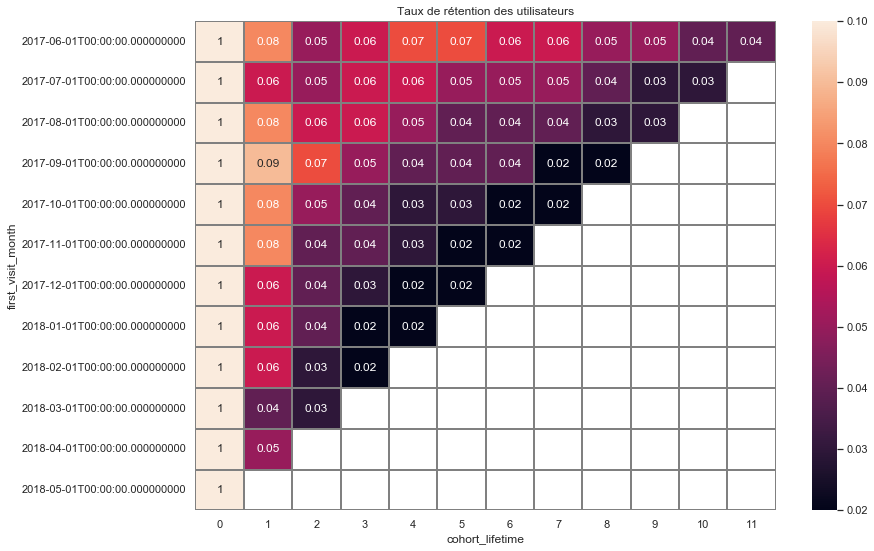

In [46]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Taux de rétention des utilisateurs')
sns.heatmap(retention_pivot, 
            annot=True, 
            linewidths=1, 
            linecolor='gray',
            vmax=0.1
           );

In [47]:
retention_pivot.columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']

In [48]:
# taux de rétention des utilisateurs au 2 mois de l'espérance de vie de la cohorte
retention_pivot['2'].mean().round(3)

0.046

### Conclusion <a id="result_product_metrics"></a>

La période d'analyse des sessions s'étend du 1er juin 2017 au 31 mai 2018. Trois métriques clés ont été étudiées : le volume quotidien(DAU), hebdomadaire(WAU) et mensuel(MAU) d'utilisateurs uniques. Le nombre moyen d'utilisateurs uniques par jour a augmenté de 500 en juin à 1200 en octobre, atteignant un pic de 3319 visites le 24 novembre 2017. Cependant, l'analyse des indicateurs quotidiens n'est pas pertinente, car le service n'est pas conçu pour une utilisation quotidienne.


Les indicateurs hebdomadaires et mensuels d'utilisateurs uniques montrent des tendances similaires. Le pic d'utilisation est survenu lors de la 47ème semaine de novembre (du 20 au 26 novembre 2017). Analyse de MAU a aussi montré que le mois de Novembre a eu le plus de visite. WAU maximale a eu 10 586 visites uniques. MAU maximale a eu 32 797 visites uniques. Les mois les plus fréquentés sont d'octobre à mars, avec plus de 27 000 visites uniques par mois.

La fréquence moyenne des sessions par utilisateur et par jour est de 1,08. Il est difficile d'affirmer une utilisation régulière.

La durée des sessions est variée, avec une moyenne de 300 secondes, ce qui est probablement insuffisant pour une visite complète du site. La mode montre encore moins, seulement 60 seconds.

Le taux de rétention des utilisateurs diminue avec le temps. Pour la cohorte d'utilisateurs ayant commencé à utiliser le service du 1er au 30 juin, ce taux est de 8% le premier mois, tandis que pour la cohorte de septembre, il est de 9%. Cela implique une stabilité dans le nombre d'utilisateurs uniques parmi les nouvelles cohortes. Le taux de rétention pour le deuxième mois de vie des cohortes est de 4,6%, ce qui indique une perte de 95% des utilisateurs après un mois.

Cela peut témoigner d'une faible capacité à maintenir l'intérêt des utilisateurs pour le site. Les gens visitent le site de manière épisodique, sans devenir des utilisateurs actifs.

## Métriques de commerce électronique <a id="e_commerce_metrics"></a>

### Temps avant le premier achat <a id="buy_time"></a>

Découvrons combien de temps il faut en moyenne depuis la première visite du site jusqu'à l'achat.

In [49]:
# informations sur les commandes

display(orders.head())
orders.info()
print()
print("Le nombre d'utilisateurs uniques :", orders['uid'].nunique())

,buy_session,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_session    50415 non-null datetime64[ns]
revenue        50415 non-null float64
uid            50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB

Le nombre d'utilisateurs uniques : 36523


In [50]:
display(visits.head())

,device,end_of_session,source_id,start_of_session,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_visit_date,first_visit_month,visit_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,51,2017-12-20,1080.0,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,8,2018-02-19,1680.0,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,26,2017-07-01,0.0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,20,2018-05-20,1440.0,2018-03-09 20:05:00,2018-03-01,2018-05-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,52,2017-12-27,0.0,2017-12-27 14:06:00,2017-12-01,2017-12-01,0


In [51]:
# ajoutons une colonne avec la date d'achat dans le tableau des commandes
# la date sans l'heure et convertissons-la au format de date
orders['order_date'] = pd.to_datetime(orders['buy_session'].dt.date)

# la colonne de la première visite au format de date et réduisons-la à la date uniquement
visits['first_visit_date'] = pd.to_datetime(visits['first_visit_date'].dt.date)

In [52]:
visit_time = visits.groupby('uid')['first_visit_date'].min().reset_index().rename_axis(None, axis=1)
visit_time.columns=['uid', 'first_visit_date']
display(visit_time.head())
visit_time.info()

,uid,first_visit_date
0,11863502262781,2018-03-01
1,49537067089222,2018-02-06
2,297729379853735,2017-06-07
3,313578113262317,2017-09-18
4,325320750514679,2017-09-30


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228169 entries, 0 to 228168
Data columns (total 2 columns):
uid                 228169 non-null uint64
first_visit_date    228169 non-null datetime64[ns]
dtypes: datetime64[ns](1), uint64(1)
memory usage: 3.5 MB


In [53]:
# сréons un tableau avec la date du premier achat pour chaque utilisateur
buy_time = orders.groupby('uid')['order_date'].min().reset_index().rename_axis(None, axis=1)
buy_time.columns=['uid', 'first_order_date']
display(buy_time.head())

,uid,first_order_date
0,313578113262317,2018-01-03
1,1575281904278712,2017-06-03
2,2429014661409475,2017-10-11
3,2464366381792757,2018-01-28
4,2551852515556206,2017-11-24


In [54]:
# créons un tableau avec le jour de la première visite et le jour du premier achat pour chaque utilisateur
buy_time_data = pd.merge(buy_time[['uid', 'first_order_date']], visit_time[['uid', 'first_visit_date']], on='uid')
display(buy_time_data)

,uid,first_order_date,first_visit_date
0,313578113262317,2018-01-03,2017-09-18
1,1575281904278712,2017-06-03,2017-06-03
2,2429014661409475,2017-10-11,2017-10-11
3,2464366381792757,2018-01-28,2018-01-27
4,2551852515556206,2017-11-24,2017-11-24
...,...,...,...
36518,18445147675727495770,2017-11-24,2017-08-20
36519,18445407535914413204,2017-09-22,2017-09-22
36520,18445601152732270159,2018-03-26,2017-08-07
36521,18446156210226471712,2018-02-18,2017-11-07


In [55]:
# calculons la différence et convertissons en minutes
buy_time_data['time_to_buy'] = \
(buy_time_data['first_order_date'] - buy_time_data['first_visit_date']).astype('timedelta64[m]')
display(buy_time_data['time_to_buy'].sort_values())

36522         0.0
21049         0.0
21046         0.0
21045         0.0
21043         0.0
           ...   
12143    514080.0
24282    514080.0
35081    515520.0
31247    522720.0
13783    522720.0
Name: time_to_buy, Length: 36523, dtype: float64

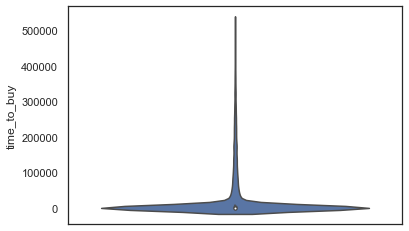

In [56]:
# Make boxplot for one group only
sns.violinplot(y=buy_time_data['time_to_buy'])
plt.show()

In [57]:
buy_time_data.head()

,uid,first_order_date,first_visit_date,time_to_buy
0,313578113262317,2018-01-03,2017-09-18,154080.0
1,1575281904278712,2017-06-03,2017-06-03,0.0
2,2429014661409475,2017-10-11,2017-10-11,0.0
3,2464366381792757,2018-01-28,2018-01-27,1440.0
4,2551852515556206,2017-11-24,2017-11-24,0.0


In [58]:
buy_time_data['time_to_buy'].describe()

count     36523.000000
mean      24330.097747
std       67782.528263
min           0.000000
25%           0.000000
50%           0.000000
75%        2880.000000
max      522720.000000
Name: time_to_buy, dtype: float64

In [59]:
print('Temps moyen avant le premier achat sur le site depuis la première visite: {} minutes'.format( 
      int(buy_time_data['time_to_buy'].mean())))

Temps moyen avant le premier achat sur le site depuis la première visite: 24330 minutes


16,9 jours

### Nombre moyen d'achats par client sur une période de  6 mois <a id="n_buys"></a>

In [60]:
#  tableau d'achats
display(buy_time_data.head())

,uid,first_order_date,first_visit_date,time_to_buy
0,313578113262317,2018-01-03,2017-09-18,154080.0
1,1575281904278712,2017-06-03,2017-06-03,0.0
2,2429014661409475,2017-10-11,2017-10-11,0.0
3,2464366381792757,2018-01-28,2018-01-27,1440.0
4,2551852515556206,2017-11-24,2017-11-24,0.0


In [61]:
orders_new = orders.merge(buy_time_data[['uid', 'first_visit_date']], on='uid')
orders_new.head()

,buy_session,revenue,uid,order_date,first_visit_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [62]:
# les achats qui ont été effectués dans les six premiers mois suivant la première visite
filtered_data = orders_new['first_visit_date'] + pd.Timedelta(days=180)
six_mois = orders_new.query('order_date < @filtered_data')
six_mois.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46906 entries, 0 to 50414
Data columns (total 5 columns):
buy_session         46906 non-null datetime64[ns]
revenue             46906 non-null float64
uid                 46906 non-null uint64
order_date          46906 non-null datetime64[ns]
first_visit_date    46906 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(1), uint64(1)
memory usage: 2.1 MB


In [63]:
six_mois.head()

,buy_session,revenue,uid,order_date,first_visit_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [64]:
x = six_mois.groupby('uid').agg({'order_date':'count'})
print("Nombre d'achat minimale par client sur une période de 6 mois :", x['order_date'].min())
print("Nombre d'achat maximale par client sur une période de 6 mois :", x['order_date'].max())
print("Nombre moyen d'achats par client sur une période de 6 mois :", round(x["order_date"].mean(), 2))

# Make boxplot for one group only
ab = x.reset_index()
ab.describe()

Nombre d'achat minimale par client sur une période de 6 mois : 1
Nombre d'achat maximale par client sur une période de 6 mois : 158
Nombre moyen d'achats par client sur une période de 6 mois : 1.32


,uid,order_date
count,3.562800e+04,35628.000000
mean,9.215581e+18,1.316549
std,5.324477e+18,2.485210
min,3.135781e+14,1.000000
25%,4.613407e+18,1.000000
50%,9.250824e+18,1.000000
75%,1.383895e+19,1.000000
max,1.844617e+19,158.000000


### Valeur moyenne des commandes <a id="revenue_avg"></a>


Calculons le panier moyen en utilisant un regroupement par moment de l'achat. L'analyse par cohorte n'est pas appropriée - elle pourrait fausser les calculs. Ensuite, construisons un graphique montrant l'évolution de la métrique dans le temps.

In [65]:
orders_new.head()

,buy_session,revenue,uid,order_date,first_visit_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [66]:
sum_order = orders_new.groupby('order_date')['revenue'].agg(['count', 'sum'])

sum_order = sum_order.reset_index().rename_axis(None, axis=1)
sum_order.columns = ['order_date', 'n_buys', 'revenue_total']

# calculons le ticket moyen par jour et ajoutons-le dans une colonne
sum_order['avg_bill'] = (sum_order['revenue_total'] / sum_order['n_buys']).round(2)
sum_order.sort_values(by='avg_bill').tail()

,order_date,n_buys,revenue_total,avg_bill
290,2018-03-18,146,1645.94,11.27
199,2017-12-17,141,1821.29,12.92
268,2018-02-24,138,1839.40,13.33
13,2017-06-14,53,710.38,13.40
192,2017-12-10,160,4661.33,29.13


In [67]:
sum_order["avg_bill"].describe()

count    364.000000
mean       4.936236
std        2.021761
min        1.950000
25%        3.960000
50%        4.560000
75%        5.410000
max       29.130000
Name: avg_bill, dtype: float64

In [68]:
print("Valeur moyenne des commandes par jour est : ", sum_order['avg_bill'].mean().round(2))

Valeur moyenne des commandes par jour est :  4.94


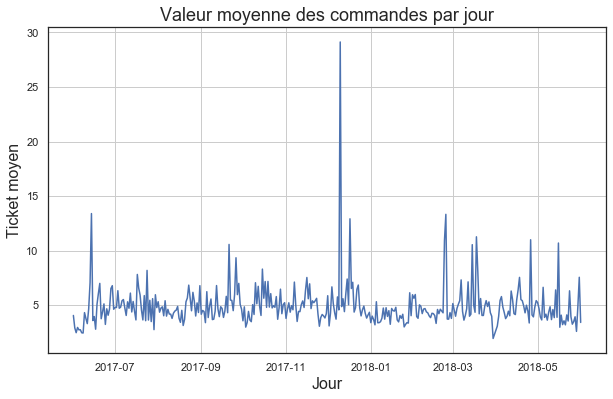

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(sum_order['order_date'], sum_order['avg_bill'])
plt.title('Valeur moyenne des commandes par jour', fontsize=18)
plt.xlabel("Jour", fontsize=16)
plt.ylabel("Ticket moyen", fontsize=16) 
plt.grid() 
plt.show()

Le graphique montre que le ticket moyen ne varie pas beaucoup au fil du temps. Tout au long de l'année, le montant moyen de la commande quotidienne était d'environ 4,94 unités monétaires.

### LTV (lifetime value) <a id="ltv"></a>

LTV représente la valeur totale qu'un client est susceptible de rapporter à une entreprise tout au long de sa relation avec celle-ci.

In [70]:
orders_new.head()

,buy_session,revenue,uid,order_date,first_visit_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [71]:
orders_new['order_month'] = orders_new['order_date'].astype('datetime64[M]')

In [72]:
# nous découvrirons le mois du premier achat de chaque client
first_orders = orders_new.groupby('uid', as_index=False).agg({'order_month': 'min'})
first_orders.columns = ['uid', 'first_order_month']
display(first_orders.head())

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [73]:
# сalculons le nombre de nouveaux acheteurs (n_buyers) chaque mois
cohort_sizes = first_orders\
    .groupby('first_order_month', as_index=False)\
    .agg({'uid': 'nunique'})

cohort_sizes.columns = ['first_order_month', 'n_buyers']
display(cohort_sizes.head())

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [74]:
# ajoutons le mois de la première commande
orders_first_month = orders_new.merge(first_orders, on='uid')
display(orders_first_month.head())

,buy_session,revenue,uid,order_date,first_visit_date,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01


In [75]:
cohorts = (
    orders_first_month.groupby(['first_order_month', 'order_month'], as_index=False)
    .agg({'revenue': 'sum'})
)
display(cohorts.head())


,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


La ligne du tableau des cohortes indique le chiffre d'affaires généré par la cohorte. Par exemple, la ligne 0 indique que les clients ayant passé leur première commande en juin 2017 ont généré un chiffre d'affaires total de 9557,49 unités monétaires au cours de ce même mois, puis ont acheté pour 981 unités monétaires le mois suivant, et ainsi de suite.

In [76]:
# ajoutons le nombre de nouveaux acheteurs (n_buyers) chaque mois
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
display(report.head())

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


In [77]:
# examinons les achats qui ont été effectués dans les six premiers mois suivant le premier achat
filtered_data_1 = report['first_order_month'] + pd.Timedelta(180, 'days')
report_new_x = report.query('order_month <= @filtered_data_1')
report_new_x.info()
display(report_new_x.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 78
Data columns (total 4 columns):
first_order_month    58 non-null datetime64[ns]
n_buyers             58 non-null int64
order_month          58 non-null datetime64[ns]
revenue              58 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 2.3 KB


,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


In [78]:
MARGIN_RATE = 1

report['gp'] = report['revenue'] * MARGIN_RATE
report['age'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report.loc[:, 'age'] = report['age'].fillna(0)
report.loc[:, 'age'] = report['age'].round().astype('int')
report['ltv'] = report['revenue'] / report['n_buyers']
display(report.head())

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531


In [79]:
result = report.query('age <= 6 and first_order_month < "2017-12-01"')
display(result.tail())

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv
52,2017-11-01,4081,2018-01-01,814.39,814.39,2,0.199556
53,2017-11-01,4081,2018-02-01,1326.13,1326.13,3,0.324952
54,2017-11-01,4081,2018-03-01,604.04,604.04,4,0.148013
55,2017-11-01,4081,2018-04-01,219.88,219.88,5,0.053879
56,2017-11-01,4081,2018-05-01,469.02,469.02,6,0.114928


In [80]:
# result['ltv'] = result['gp'] / result['n_buyers']
result['first_order_month'] = result['first_order_month'].dt.strftime('%Y-%m')


output = result.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean'
).round(2)

output.fillna('')

/Users/alinasajous/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


age,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06,4.72,0.49,0.44,0.95,1.02,0.74,0.95
2017-07,6.01,0.34,0.62,0.36,0.18,0.16,0.12
2017-08,5.28,0.47,0.46,0.39,0.49,0.28,0.21
2017-09,5.64,1.12,0.52,3.98,0.40,0.65,0.70
2017-10,5.00,0.54,0.19,0.16,0.15,0.12,0.08
2017-11,5.15,0.40,0.20,0.32,0.15,0.05,0.11


In [81]:
# Créons le tableau
ltv_avg_in_6_months = output.reset_index().rename_axis(None, axis=1)

ltv_avg_in_6_months['ltv_sum'] = ltv_avg_in_6_months.sum(axis=1)
display(ltv_avg_in_6_months)

,first_order_month,0,1,2,3,4,5,6,ltv_sum
0,2017-06,4.72,0.49,0.44,0.95,1.02,0.74,0.95,9.31
1,2017-07,6.01,0.34,0.62,0.36,0.18,0.16,0.12,7.79
2,2017-08,5.28,0.47,0.46,0.39,0.49,0.28,0.21,7.58
3,2017-09,5.64,1.12,0.52,3.98,0.40,0.65,0.70,13.01
4,2017-10,5.00,0.54,0.19,0.16,0.15,0.12,0.08,6.24
5,2017-11,5.15,0.40,0.20,0.32,0.15,0.05,0.11,6.38


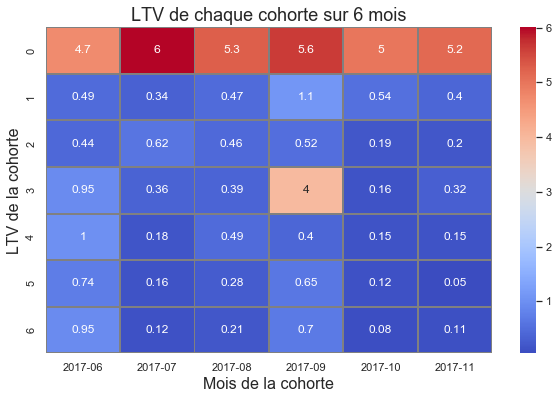

In [82]:
plt.figure(figsize=(10, 6))
sns.heatmap(output.T,
            cmap= 'coolwarm', 
            linewidths=1, 
            linecolor='gray',
           annot=True)
plt.title('LTV de chaque cohorte sur 6 mois', fontsize=18) 
plt.xlabel("Mois de la cohorte", fontsize=16) 
plt.ylabel("LTV de la cohorte", fontsize=16)
plt.grid() 
plt.show()

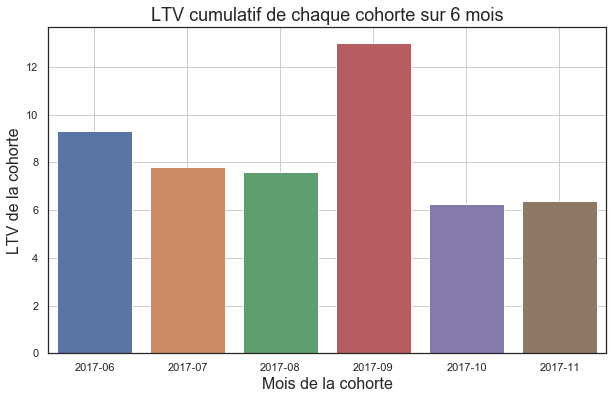

In [83]:
plt.figure(figsize=(10, 6))
sns.barplot(x='first_order_month', y='ltv_sum', data = ltv_avg_in_6_months)
plt.title('LTV cumulatif de chaque cohorte sur 6 mois', fontsize=18) 
plt.xlabel("Mois de la cohorte", fontsize=16) 
plt.ylabel("LTV de la cohorte", fontsize=16)
plt.grid() 
plt.show()

### Conclusion <a id="result_e_commerce_metrics"></a>

Grâce aux métriques de commerce électronique on a pu decouvrir:
- Temps moyen avant le premier achat sur le site depuis la première visite est 24330 minutes (16,9 jours)
- Nombre moyen d'achats par client sur une période de 6 mois est 1.32
- Le ticket moyen ne varie pas beaucoup au fil du temps. Tout au long de l'année, le montant moyen de la commande quotidienne était d'environ 4,94 unités monétaires
- Le montant moyen maximal de la facture a été identifié le 10 décembre 2017 et s'élevait à 29,13 unités monétaires
- Pour la cohorte de septembre, le LTV total est le plus élevé. Sur les 6 mois de 'vie', il a atteint 14 unités monétaires par client. 

## Métriques marketing <a id="marketing_metrics"></a>

### Dépensent en marketing <a id="marketing_costs"></a>

In [84]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [85]:
costs['dt'] = pd.to_datetime(costs['dt'].dt.date)

In [86]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [87]:
# regroupons par mois et par source. Trouvons la somme des dépenses
costs_month = costs.groupby(['month','source_id'], as_index=False)[['costs']].sum()
costs_month = costs_month.add_suffix('_x')
display(costs_month.head())

,month_x,source_id_x,costs_x
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


In [88]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs['month'] = costs['dt'].dt.strftime('%Y-%m')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 4 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
month        2542 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 79.6+ KB


In [89]:
# сalculons le montant total des dépenses en marketing
sum_total = costs['costs'].sum()
print('Le montant total des dépenses en marketing est {} unités monétaires'.format(sum_total))

Le montant total des dépenses en marketing est 329131.62 unités monétaires


In [90]:
costs_source_id = costs.groupby('source_id', as_index=False).sum()
display(costs_source_id.sort_values(by='costs', ascending=False))

,source_id,costs
2,3,141321.63
3,4,61073.60
4,5,51757.10
1,2,42806.04
0,1,20833.27
6,10,5822.49
5,9,5517.49


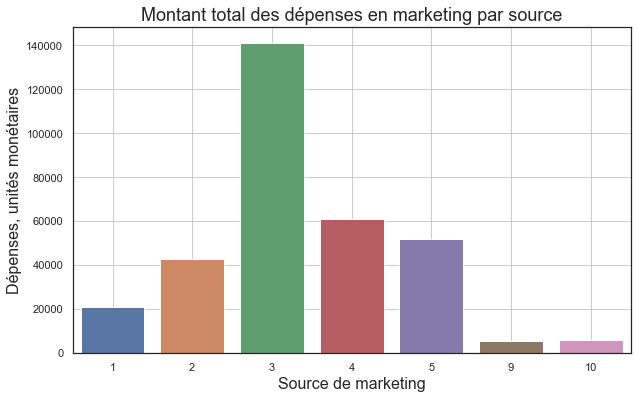

In [91]:
plt.figure(figsize=(10, 6))
sns.barplot(x='source_id', y='costs', data = costs_source_id)
plt.title('Montant total des dépenses en marketing par source', fontsize=18) 
plt.xlabel("Source de marketing", fontsize=16) 
plt.ylabel("Dépenses, unités monétaires", fontsize=16)
plt.grid() 
plt.show()

In [92]:
# examinons la répartition des dépenses par sources
costs_marketing = costs.pivot_table(
    index='source_id',
    columns='month',
    values='costs',
    aggfunc='sum')

In [93]:
display(costs_marketing)

month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
source_id,,,,,,,,,,,,
1,1125.61,1072.88,951.81,1502.01,2315.75,2445.16,2341.20,2186.18,2204.48,1893.09,1327.49,1467.61
2,2427.38,2333.11,1811.05,2985.66,4845.00,5247.68,4897.80,4157.74,4474.34,3943.14,2993.70,2689.44
3,7731.65,7674.37,6143.54,9963.55,15737.24,17025.34,16219.52,14808.78,14228.56,13080.85,9296.81,9411.42
4,3514.80,3529.73,3217.36,5192.26,6420.84,5388.82,7680.47,5832.79,5711.96,5961.87,4408.49,4214.21
5,2616.12,2998.14,2185.28,3849.14,5767.40,6325.34,5872.52,5371.52,5071.31,4529.62,3501.15,3669.56
9,285.22,302.54,248.93,415.62,609.41,683.18,657.98,547.16,551.50,480.29,373.49,362.17
10,314.22,329.82,232.57,460.67,627.24,792.36,645.86,614.35,480.88,526.41,388.25,409.86


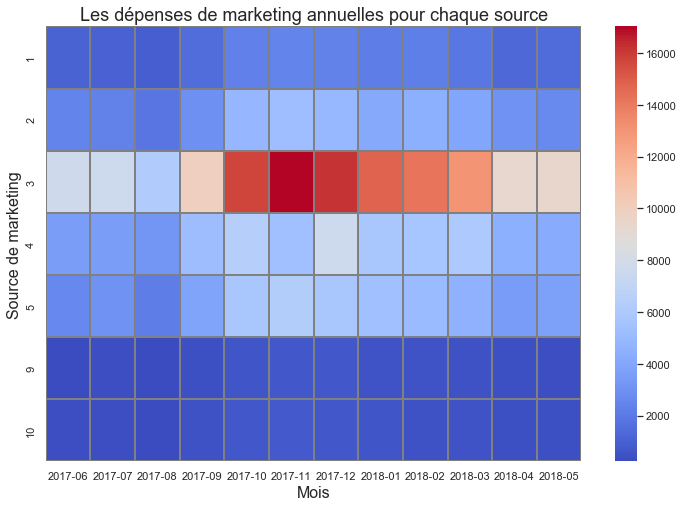

In [94]:
plt.figure(figsize=(12,8))
sns.heatmap(costs_marketing, 
            cmap= 'coolwarm', 
            linewidths=1, 
            linecolor='gray')
plt.title('Les dépenses de marketing annuelles pour chaque source', fontsize=18)
plt.xlabel('Mois', fontsize=16)
plt.ylabel('Source de marketing', fontsize=16); 

Le montant total des dépenses de marketing s'élève à 329 131,62 unités monétaires. Les dépenses les plus élevées en marketing ont été donnés à la troisième source publicitaire. En avril 2018, les dépenses pour celle-ci se sont élevées à 17 025,34 unités monétaires.

### Coût d'acquisition client CAC <a id="cac"></a>

Calculons le CAC moyen par client pour l'ensemble du projet et pour chaque source de trafic. Démontrons l'évolution de la métrique sur un graphique.

#### Formons un tableau `users_sources`

In [95]:
# nous allons trier par durée de la session pour obtenir 1 source en fonction du temps
users_sources = visits\
                    .sort_values(by='start_of_session')\
                    .groupby('uid', as_index=False)\
                    .agg({'source_id': 'first'})
display(users_sources.head())

,uid,source_id
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5


#### Fusionnons les tables  `users_sources` et `orders` par le champ `uid`

In [96]:
orders.head()

,buy_session,revenue,uid,order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


In [97]:
orders['order_month'] = orders['order_date'].astype('datetime64[M]') 
orders['order_month'] = orders['order_date'].dt.strftime('%Y-%m')
orders.head() 

,buy_session,revenue,uid,order_date,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06


In [98]:
orders_with_sources = orders.merge(users_sources, on='uid')
display(orders_with_sources.head())

,buy_session,revenue,uid,order_date,order_month,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06,3


#### Nous agrégeons le tableau `orders_with_sources` par source et calculons le nombre de clients uniques - nous sauvegardons dans le tableau `n_buyers_by_source`

In [99]:
n_buyers_by_source_x = orders_with_sources\
                        .groupby(['source_id', 'order_month'], as_index=False)\
                        .agg({'uid': 'nunique'})\
                        .rename(columns={'uid': 'n_buyers'}) 
n_buyers_by_source_x.head()

,source_id,order_month,n_buyers
0,1,2017-06,190
1,1,2017-07,176
2,1,2017-08,128
3,1,2017-09,255
4,1,2017-10,376


In [100]:
n_buyers_by_source = orders_with_sources\
                        .groupby('source_id', as_index=False)\
                        .agg({'uid': 'nunique'})\
                        .rename(columns={'uid': 'n_buyers'})
n_buyers_by_source

,source_id,n_buyers
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


### Nous agrégeons la table `costs` par source et calculons les coûts totaux par source - enregistrés dans la table `costs_by_source`

In [101]:
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06
1,1,2017-06-02,62.25,2017-06
2,1,2017-06-03,36.53,2017-06
3,1,2017-06-04,55.00,2017-06
4,1,2017-06-05,57.08,2017-06


In [102]:
costs_by_source_x = costs.groupby(['source_id', 'month'], as_index=False).agg({'costs': 'sum'}) 
costs_by_source_x.head()

,source_id,month,costs
0,1,2017-06,1125.61
1,1,2017-07,1072.88
2,1,2017-08,951.81
3,1,2017-09,1502.01
4,1,2017-10,2315.75


In [103]:
costs_by_source = costs.groupby('source_id', as_index=False).agg({'costs': 'sum'})
costs_by_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


### Nous fusionnons les tables `n_buyers_by_source` et `costs_by_source` par `source_id` - calculons le CAC = coûts / n_acheteurs

In [104]:
total_cac_by_source_x = n_buyers_by_source_x.merge(costs_by_source_x, left_on=['source_id', 'order_month'],
                                                  right_on=['source_id', 'month'])\
    .assign(CAC=lambda row: row['costs'] / row['n_buyers'])\
    .sort_values(by='CAC')
total_cac_by_source_x

,source_id,order_month,n_buyers,month,costs,CAC
69,9,2018-03,205,2018-03,480.29,2.342878
81,10,2018-03,199,2018-03,526.41,2.645276
83,10,2018-05,143,2018-05,409.86,2.866154
76,10,2017-10,215,2017-10,627.24,2.917395
82,10,2018-04,118,2018-04,388.25,3.290254
...,...,...,...,...,...,...
29,3,2017-11,1310,2017-11,17025.34,12.996443
14,2,2017-08,139,2017-08,1811.05,13.029137
31,3,2018-01,1130,2018-01,14808.78,13.105115
25,3,2017-07,525,2017-07,7674.37,14.617848


In [105]:
total_cac_by_source = n_buyers_by_source.merge(costs_by_source, on='source_id')\
    .assign(cac=lambda row: row['costs'] / row['n_buyers'])\
    .sort_values(by='cac')
total_cac_by_source

,source_id,n_buyers,costs,cac
6,10,1329,5822.49,4.381106
5,9,1088,5517.49,5.071222
3,4,10296,61073.60,5.931779
0,1,2899,20833.27,7.186364
4,5,6931,51757.10,7.467479
1,2,3506,42806.04,12.209367
2,3,10473,141321.63,13.493901


### Visualisons le CAC (Coût d'Acquisition Client)

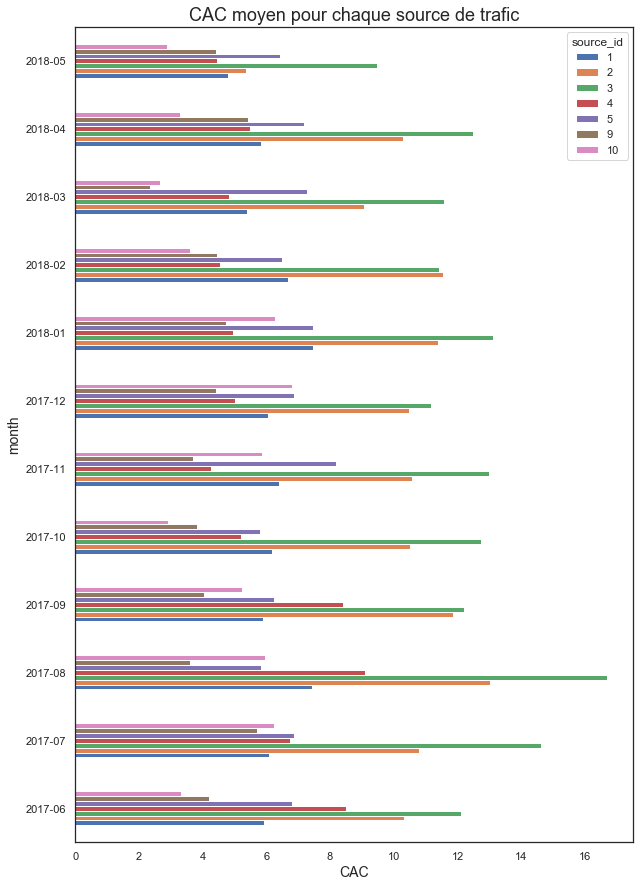

In [106]:
df = total_cac_by_source_x.pivot(index='month', columns='source_id', values='CAC')


fig, ax = plt.subplots(figsize=(10, 15))
ax.set_title('CAC moyen pour chaque source de trafic', fontsize=18)
ax.set_xlabel('CAC', fontsize=14)
ax.set_ylabel("Mois d'acquisition", fontsize=14)
ax.grid(color='grey', alpha=0.5, lw=0.5)
df.plot(kind='barh', ax=ax);

Nous pouvons noter que la source la plus coûteuse en termes d'acquisition de clients est la troisième. Les sources les moins coûteuses sont les neuvième et dixième.

### ROMI par cohortes selon les sources <a id="romi"></a>

In [107]:
# ajoutons le mois de la première commande dans le dataframe aux commandes avec la source
orders_first_month_source = orders_with_sources.merge(first_orders, on='uid')
display(orders_first_month_source.head())

,buy_session,revenue,uid,order_date,order_month,source_id,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06,1,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06,2,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06,2,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06,2,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06,3,2017-06-01


In [108]:
orders_first_month_source['first_order_month'] = pd.to_datetime(orders_first_month_source['first_order_month'])
orders_first_month_source['order_month'] = pd.to_datetime(orders_first_month_source['order_month'])
orders_first_month_source.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 7 columns):
buy_session          50415 non-null datetime64[ns]
revenue              50415 non-null float64
uid                  50415 non-null uint64
order_date           50415 non-null datetime64[ns]
order_month          50415 non-null datetime64[ns]
source_id            50415 non-null int64
first_order_month    50415 non-null datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), uint64(1)
memory usage: 3.1 MB


In [109]:
# calculons le nombre de nouveaux acheteurs (n_buyers) pour chaque mois.
cohort_sizes_y = (
    orders_first_month_source.groupby(['source_id', 'first_order_month'], as_index=False)
    .agg({'uid': 'nunique'})
)
cohort_sizes_y.columns = ['source_id', 'first_order_month', 'n_buyers']
print(cohort_sizes_y.head())

   source_id first_order_month  n_buyers
0          1        2017-06-01       190
1          1        2017-07-01       160
2          1        2017-08-01       113
3          1        2017-09-01       227
4          1        2017-10-01       340


In [110]:
# egroupons le tableau des commandes par mois du premier achat et par mois de chaque commande, 
# et additionnons le chiffre d'affaires

cohorts_y = (
    orders_first_month_source.groupby(['source_id', 'first_order_month', 'order_month'], as_index=False)
    .agg({'revenue': 'sum'})
)
print(cohorts_y.head())

   source_id first_order_month order_month  revenue
0          1        2017-06-01  2017-06-01  1378.70
1          1        2017-06-01  2017-07-01   414.98
2          1        2017-06-01  2017-08-01   419.43
3          1        2017-06-01  2017-09-01   714.24
4          1        2017-06-01  2017-10-01   811.20


In [111]:
# ajoutons dans le tableau cohorts_y des données sur le nombre de personnes 
# qui ont effectué un premier achat chaque mois pour chaque source

report_y = pd.merge(cohort_sizes_y, cohorts_y, on=['source_id', 'first_order_month'])
print(report_y.head())

   source_id first_order_month  n_buyers order_month  revenue
0          1        2017-06-01       190  2017-06-01  1378.70
1          1        2017-06-01       190  2017-07-01   414.98
2          1        2017-06-01       190  2017-08-01   419.43
3          1        2017-06-01       190  2017-09-01   714.24
4          1        2017-06-01       190  2017-10-01   811.20


In [112]:
report_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 516 entries, 0 to 515
Data columns (total 5 columns):
source_id            516 non-null int64
first_order_month    516 non-null datetime64[ns]
n_buyers             516 non-null int64
order_month          516 non-null datetime64[ns]
revenue              516 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 24.2 KB


In [113]:
margin_rate = 1

report_y['gp'] = report_y['revenue'] * margin_rate
report_y['age'] = (
    report_y['order_month'] - report_y['first_order_month']
) / np.timedelta64(1, 'M')
report_y['age'] = report_y['age'].round().astype('int')

# trouvons LTV
report_y['LTV'] = report_y['gp'] / report_y['n_buyers']
display(report_y.head())

,source_id,first_order_month,n_buyers,order_month,revenue,gp,age,LTV
0,1,2017-06-01,190,2017-06-01,1378.70,1378.70,0,7.256316
1,1,2017-06-01,190,2017-07-01,414.98,414.98,1,2.184105
2,1,2017-06-01,190,2017-08-01,419.43,419.43,2,2.207526
3,1,2017-06-01,190,2017-09-01,714.24,714.24,3,3.759158
4,1,2017-06-01,190,2017-10-01,811.20,811.20,4,4.269474


In [114]:
total_cac_by_source_x['month'] = pd.to_datetime(total_cac_by_source_x['month'])
total_cac_by_source_x

,source_id,order_month,n_buyers,month,costs,CAC
69,9,2018-03,205,2018-03-01,480.29,2.342878
81,10,2018-03,199,2018-03-01,526.41,2.645276
83,10,2018-05,143,2018-05-01,409.86,2.866154
76,10,2017-10,215,2017-10-01,627.24,2.917395
82,10,2018-04,118,2018-04-01,388.25,3.290254
...,...,...,...,...,...,...
29,3,2017-11,1310,2017-11-01,17025.34,12.996443
14,2,2017-08,139,2017-08-01,1811.05,13.029137
31,3,2018-01,1130,2018-01-01,14808.78,13.105115
25,3,2017-07,525,2017-07-01,7674.37,14.617848


In [115]:
# fusionnons le tableau par CAC et LTV par source et par mois
report_z = pd.merge(report_y, total_cac_by_source_x,
                    left_on = ['source_id', 'first_order_month'],
                    right_on = ['source_id', 'month'])

# calculons le ROMI : divisons le LTV par le CAC.
report_z['ROMI'] = report_z['LTV'] / report_z['CAC']

display(report_z)

,source_id,first_order_month,n_buyers_x,order_month_x,revenue,gp,age,LTV,order_month_y,n_buyers_y,month,costs,CAC,ROMI
0,1,2017-06-01,190,2017-06-01,1378.70,1378.70,0,7.256316,2017-06,190,2017-06-01,1125.61,5.924263,1.224847
1,1,2017-06-01,190,2017-07-01,414.98,414.98,1,2.184105,2017-06,190,2017-06-01,1125.61,5.924263,0.368671
2,1,2017-06-01,190,2017-08-01,419.43,419.43,2,2.207526,2017-06,190,2017-06-01,1125.61,5.924263,0.372625
3,1,2017-06-01,190,2017-09-01,714.24,714.24,3,3.759158,2017-06,190,2017-06-01,1125.61,5.924263,0.634536
4,1,2017-06-01,190,2017-10-01,811.20,811.20,4,4.269474,2017-06,190,2017-06-01,1125.61,5.924263,0.720676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,10,2018-03-01,186,2018-03-01,638.44,638.44,0,3.432473,2018-03,199,2018-03-01,526.41,2.645276,1.297586
510,10,2018-03-01,186,2018-04-01,12.71,12.71,1,0.068333,2018-03,199,2018-03-01,526.41,2.645276,0.025832
511,10,2018-03-01,186,2018-05-01,6.29,6.29,2,0.033817,2018-03,199,2018-03-01,526.41,2.645276,0.012784
512,10,2018-04-01,107,2018-04-01,261.93,261.93,0,2.447944,2018-04,118,2018-04-01,388.25,3.290254,0.743998


In [116]:
output_z = report_z.pivot_table(
    index=['source_id', 'first_order_month'], columns='age', values='ROMI', aggfunc='mean'
)
output_cumsum_z = output_z.cumsum(axis=1).round(2)
display(output_cumsum_z.head(24))
display(output_cumsum_z.tail(24))

age                            0     1     2     3     4     5     6     7   \
source_id first_order_month                                                   
1         2017-06-01         1.22  1.59  1.97  2.60  3.32  3.67  4.10  4.53   
          2017-07-01         1.20  1.38  2.25  2.50  2.65  2.79  2.87  2.97   
          2017-08-01         1.01  1.17  1.30  1.43  1.57  1.66  1.76  2.11   
          2017-09-01         1.02  1.33  1.42  1.58  1.59  1.60  1.62  1.67   
          2017-10-01         0.98  1.15  1.19  1.25  1.26  1.28  1.31  1.36   
          2017-11-01         1.16  1.25  1.40  1.54  1.56  1.58  1.59   NaN   
          2017-12-01         0.76  0.81  0.86  0.90  0.90  0.92   NaN   NaN   
          2018-01-01         0.77  0.79  0.80  0.94  0.94   NaN   NaN   NaN   
          2018-02-01         0.70  0.85  0.86  0.92   NaN   NaN   NaN   NaN   
          2018-03-01         1.73  2.09  2.24   NaN   NaN   NaN   NaN   NaN   
          2018-04-01         0.81  0.85   NaN   NaN   NaN   NaN   NaN   NaN   
          2018-05-01         1.09   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2         2017-06-01         0.43  0.48  0.50  0.69  0.85  0.94  1.10  1.24   
          2017-07-01         0.78  0.85  0.86  0.89  0.93  0.94  0.97  0.98   
          2017-08-01         0.44  0.51  0.53  0.55  0.58  0.59  0.60  0.63   
          2017-09-01         0.70  1.39  1.58  1.66  1.78  1.86  2.14  2.21   
          2017-10-01         0.73  0.96  1.03  1.08  1.13  1.16  1.17  1.19   
          2017-11-01         0.66  0.75  0.79  0.86  0.89  0.91  0.92   NaN   
          2017-12-01         0.84  0.99  1.88  2.94  3.23  3.53   NaN   NaN   
          2018-01-01         0.38  0.48  0.63  0.65  0.68   NaN   NaN   NaN   
          2018-02-01         0.47  0.52  0.55  0.57   NaN   NaN   NaN   NaN   
          2018-03-01         0.58  0.67  0.80   NaN   NaN   NaN   NaN   NaN   
          2018-04-01         0.56  0.61   NaN   NaN   NaN   NaN   NaN   NaN   
          2018-05-01         1.28   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

age                            8     9     10    11  
source_id first_order_month                          
1         2017-06-01         4.91  5.19  5.40  5.68  
          2017-07-01         3.11  3.27  3.43   NaN  
          2017-08-01         2.41  2.51   NaN   NaN  
          2017-09-01         1.77   NaN   NaN   NaN  
          2017-10-01          NaN   NaN   NaN   NaN  
          2017-11-01          NaN   NaN   NaN   NaN  
          2017-12-01          NaN   NaN   NaN   NaN  
          2018-01-01          NaN   NaN   NaN   NaN  
          2018-02-01          NaN   NaN   NaN   NaN  
          2018-03-01          NaN   NaN   NaN   NaN  
          2018-04-01          NaN   NaN   NaN   NaN  
          2018-05-01          NaN   NaN   NaN   NaN  
2         2017-06-01         1.37  1.44  1.57  1.61  
          2017-07-01         0.99  1.02  1.05   NaN  
          2017-08-01         0.63  0.64   NaN   NaN  
          2017-09-01         2.25   NaN   NaN   NaN  
          2017-10-01          NaN   NaN   NaN   NaN  
          2017-11-01          NaN   NaN   NaN   NaN  
          2017-12-01          NaN   NaN   NaN   NaN  
          2018-01-01          NaN   NaN   NaN   NaN  
          2018-02-01          NaN   NaN   NaN   NaN  
          2018-03-01          NaN   NaN   NaN   NaN  
          2018-04-01          NaN   NaN   NaN   NaN  
          2018-05-01          NaN   NaN   NaN   NaN

age                            0     1     2     3     4     5     6     7   \
source_id first_order_month                                                   
9         2017-06-01         0.85  0.87  1.01  1.15  1.22  1.32  1.45  1.48   
          2017-07-01         0.78  0.81  0.92  1.01  1.07  1.08  1.13  1.14   
          2017-08-01         1.13  1.18  1.36  1.43  1.44  1.46  1.50  1.58   
          2017-09-01         1.06  1.32  1.47  1.67  1.82  1.85  2.01  2.17   
          2017-10-01         1.33  1.47  1.59  1.62  1.69  1.83  1.84  1.84   
          2017-11-01         1.01  1.05  1.09  1.17  1.21  1.22  1.23   NaN   
          2017-12-01         0.87  0.94  0.98  1.04  1.04  1.08   NaN   NaN   
          2018-01-01         0.60  0.65  0.69  0.70  0.70   NaN   NaN   NaN   
          2018-02-01         1.08  1.12  1.14   NaN   NaN   NaN   NaN   NaN   
          2018-03-01         1.12  1.15  1.19   NaN   NaN   NaN   NaN   NaN   
          2018-04-01         0.94  1.04   NaN   NaN   NaN   NaN   NaN   NaN   
          2018-05-01         0.84   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
10        2017-06-01         0.73  0.77   NaN   NaN   NaN   NaN   NaN   NaN   
          2017-07-01         0.56  0.56   NaN  0.59   NaN   NaN   NaN   NaN   
          2017-08-01         0.84  0.86  0.91   NaN   NaN   NaN   NaN  0.93   
          2017-09-01         0.43  0.44  0.45  0.49  0.50   NaN   NaN  0.50   
          2017-10-01         0.90  0.93  0.93  0.94  0.95  0.95  0.96  0.98   
          2017-11-01         0.79  0.80  0.80  0.83  0.85  0.86  0.87   NaN   
          2017-12-01         0.56  0.58   NaN   NaN   NaN  0.59   NaN   NaN   
          2018-01-01         0.49  0.50  0.51   NaN   NaN   NaN   NaN   NaN   
          2018-02-01         0.69  0.72  0.72   NaN   NaN   NaN   NaN   NaN   
          2018-03-01         1.30  1.32  1.34   NaN   NaN   NaN   NaN   NaN   
          2018-04-01         0.74   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
          2018-05-01         1.26   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

age                            8     9     10  11  
source_id first_order_month                        
9         2017-06-01         1.61  1.64  1.66 NaN  
          2017-07-01         1.22  1.22  1.23 NaN  
          2017-08-01         1.60  1.64   NaN NaN  
          2017-09-01         2.40   NaN   NaN NaN  
          2017-10-01          NaN   NaN   NaN NaN  
          2017-11-01          NaN   NaN   NaN NaN  
          2017-12-01          NaN   NaN   NaN NaN  
          2018-01-01          NaN   NaN   NaN NaN  
          2018-02-01          NaN   NaN   NaN NaN  
          2018-03-01          NaN   NaN   NaN NaN  
          2018-04-01          NaN   NaN   NaN NaN  
          2018-05-01          NaN   NaN   NaN NaN  
10        2017-06-01         0.77   NaN   NaN NaN  
          2017-07-01         0.59   NaN   NaN NaN  
          2017-08-01          NaN  0.95   NaN NaN  
          2017-09-01         0.50   NaN   NaN NaN  
          2017-10-01          NaN   NaN   NaN NaN  
          2017-11-01          NaN   NaN   NaN NaN  
          2017-12-01          NaN   NaN   NaN NaN  
          2018-01-01          NaN   NaN   NaN NaN  
          2018-02-01          NaN   NaN   NaN NaN  
          2018-03-01          NaN   NaN   NaN NaN  
          2018-04-01          NaN   NaN   NaN NaN  
          2018-05-01          NaN   NaN   NaN NaN

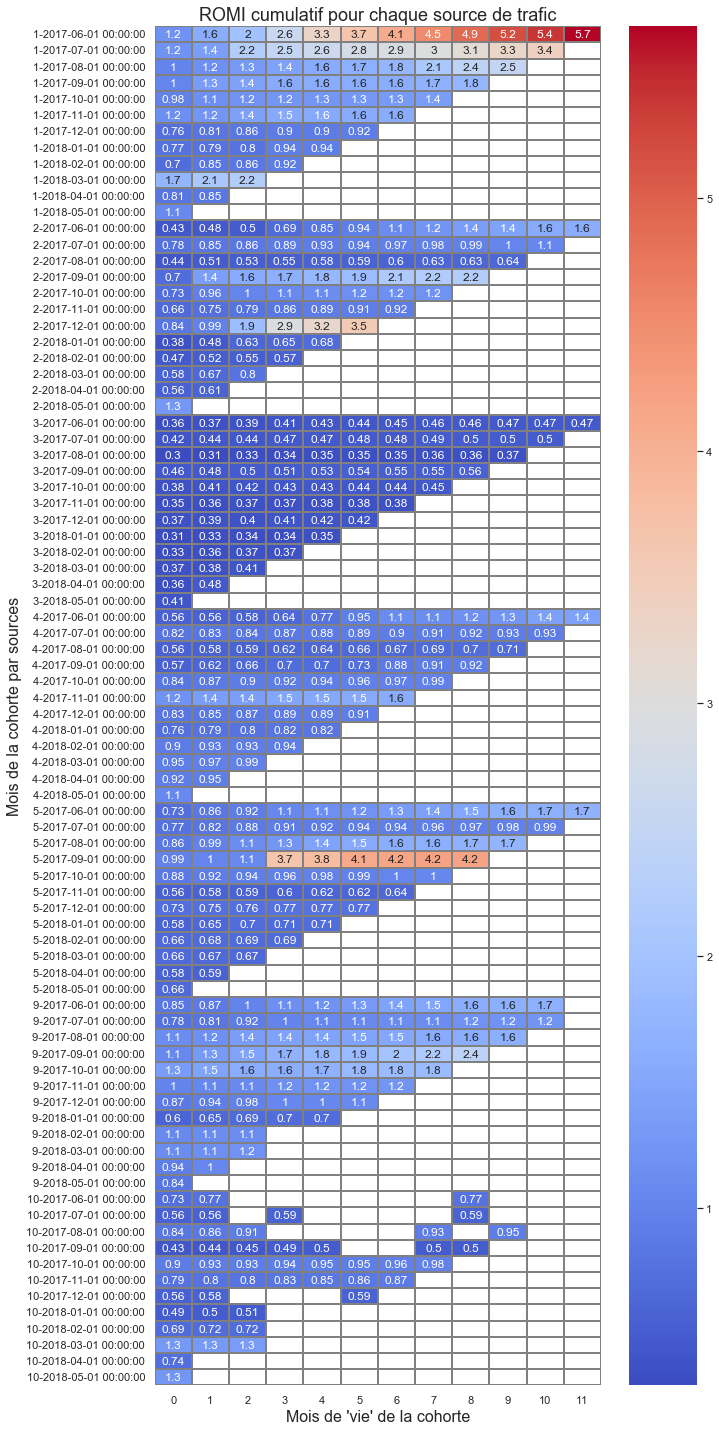

In [117]:
fig1, ax1 = plt.subplots(figsize=(10, 25))
ax1.set_title('ROMI cumulatif pour chaque source de trafic', fontsize=18)
ax1.grid(color='grey', alpha=0.5, lw=0.5)
sns.heatmap(output_cumsum_z,
           cmap= 'coolwarm', 
            linewidths=1, 
            linecolor='gray',
           annot=True)

plt.xlabel("Mois de 'vie' de la cohorte", fontsize=16) 
plt.ylabel('Mois de la cohorte par sources', fontsize=16);

# Conclusion <a id="result_total)"></a>

Dans ce projet, nous avons étudié les données sur les visites du site web, les informations sur les commandes et les dépenses liées au marketing.

Tout d'abord, nous avons identifié 7 sources publicitaires.

Nous avons examiné 3 types de métriques : les métriques de produits, les métriques de commerce électronique et les métriques de marketing.

Pour les métriques produit, une évaluation de l'activité des utilisateurs a été calculée. Le nombre d'utilisateurs uniques par semaine et par mois a montré que la plupart des utilisateurs ont été enregistrés en juin, juillet et août. Le nombre moyen de sessions par jour par utilisateur est de 1,08. La répartition au cours de l'année peut être considérée comme uniforme. Cependant, la durée des sessions n'est pas uniformément répartie. La durée moyenne d'une session était de 60 secondes.

Le taux de rétention des utilisateurs, également appelé Retention Rate, diminue avec le temps pour les différentes cohortes. Par exemple, pour la cohorte d'utilisateurs arrivés entre le 1er juillet et le 31 juillet, le taux de rétention lors de la première semaine est de 6%. Pour ceux arrivés entre le 1er et le 30 août, il est de 8%. Ainsi, en février, toutes les cohortes n'ont pu conserver que 2 à 5% de leurs utilisateurs. Cela signifie que le nombre d'utilisateurs uniques reste constant avec chaque nouvelle cohorte. Le taux de rétention pour le deuxième mois de vie des cohortes est de 4.8%, ce qui signifie que le site perd déjà 95% de ses utilisateurs au bout d'1 à 2 mois.

Probablement, cela signifie qu'il est difficile de maintenir l'intérêt des utilisateurs. Les gens se souviennent du site de temps en temps et ne sont pas des utilisateurs actifs.

Grâce aux métriques de commerce électronique on a pu decouvrir:
- Temps moyen avant le premier achat sur le site depuis la première visite est 24330 minutes (16,9 jours)
- Nombre moyen d'achats par client sur une période de 6 mois est 1.32
- Le ticket moyen ne varie pas beaucoup au fil du temps. Tout au long de l'année, le montant moyen de la commande quotidienne était d'environ 4,94 unités monétaires
- Le montant moyen maximal de la facture a été identifié le 10 décembre 2017 et s'élevait à 29,13 unités monétaires
- Pour la cohorte de septembre, le LTV total est le plus élevé. Sur les 6 mois de 'vie', il a atteint 14 unités monétaires par client. 

La dernière étape a consisté à calculer les métriques marketing, à savoir le CAC (Coût d'Acquisition Client) et le ROMI (Retour sur Investissement Marketing).

Ainsi, les dépenses totales en marketing se montent à 32 9131,62 unités monétaires. Les dépenses les plus élevées en marketing ont été allouées au troisième canal publicitaire, avec des dépenses s'élevant à 141 321,63 unités monétaires sur l'ensemble de l'année. Les dépenses les plus faibles en marketing sont observées pour les sources 9 et 10, totalisant environ 55 000 unités monétaires.

Il est également important de noter que le CAC moyen le plus élevé est également observé pour la source 3. La moyenne des coûts d'acquisition client augmente au fil de l'année pour les sources 1, 2, 3 et 5.

Pour calculer le ROMI (Retour sur Investissement Marketing) par cohortes en fonction des sources, les CAC (Coûts d'Acquisition Client) et LTV (Valeur Vie Client) ont été recalculés. Le ROMI le plus élevé a été observé pour les sources 1 et 9. Dès le premier mois de vie des cohortes, ils ont couvert leurs coûts d'acquisition. En revanche, la source 3 n'est pas rentable.

Ainsi, les cohortes de juin et septembre se révèlent être les plus prometteuses, car elles présentent la valeur vie client maximale. En tant que recommandations pour les spécialistes du marketing, il est conseillé de se concentrer sur les sources 1 et 9, et éventuellement de renoncer à la source 3.